## 1. Module Import and Hyper-parameters Setting

### 1-1. Setup & Module Import

In [3]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, QuantumRegister, ClassicalRegister, Aer
from qiskit.circuit import ParameterVector
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.utils import algorithm_globals

#from qiskit_machine_learning.neural_networks import EstimatorQNN
#from qiskit.primitives import Estimator

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibmq_qasm_simulator")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

# Importing Matplotlib & Numpy
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy.random import default_rng

from IPython.display import clear_output

### 1-2. Setting of the main hyper-parameters of the model

In [28]:
BATCH_SIZE = 100
N_QUBITS = 4 # Number of qubits allocated to each of two quantum registers. Number of Ansatz input Qubits = 2 * N_QUBITS - 2, RUS input Qubits = N_QUBITS - 1
N_STEPS = 2
N_SHOTS = 1024

# Those parameters are determined by above parameters
N_ANSATZ_QUBITS = 2*N_QUBITS - 1
N_HIDDEN_QUBITS = N_QUBITS - 1
N_RUS_QUBITS = N_QUBITS - 1
N_TOTAL_QUBITS = N_ANSATZ_QUBITS + N_RUS_QUBITS
N_PARAMS = 8 * N_ANSATZ_QUBITS * N_STEPS
N_THETAS = N_RUS_QUBITS * N_STEPS
# iteration = 100
# N_EPOCHS = 30
# N_LAYERS = 1    # Number of random layers

# SAVE_PATH = "aeqis/" # Data saving folder
SEED = 23
np.random.seed(SEED)        # Seed for NumPy random number generator
rng = default_rng(SEED)
algorithm_globals.random_seed = SEED

isReal = False # 'True' for real device or 'False' for simulator
# use_gpu = False

### 1-3. Data loading

In [23]:
# Code fot data loading
input_data = np.random.rand(N_STEPS) * 2
input_data -= 1
print(input_data)
print(np.arccos(input_data))

[0.03459577 0.89392521]
[1.53619365 0.46476882]


## 2. Construct Quantum Circuit

### 2-1. Initializing

In [29]:
# Setup a base quantum circuit for our experiments
"""
reg_d is used to embed the sequential data, one element at each time step
reg_h is used to store information about the history of all previous elements
"""
qr_ansatz = QuantumRegister(N_ANSATZ_QUBITS + N_ANSATZ_QUBITS)
reg_d = qr_ansatz[0:N_QUBITS]
reg_h = qr_ansatz[N_QUBITS:N_ANSATZ_QUBITS]
reg_ansatz = qr_ansatz[0:N_ANSATZ_QUBITS]
reg_rus = qr_ansatz[N_ANSATZ_QUBITS:N_TOTAL_QUBITS]

# Output at each time step
cr_y = ClassicalRegister(N_STEPS, name='cr_y')
cr_x = ClassicalRegister(N_RUS_QUBITS*N_STEPS, name='cr_x')
cr_rus = ClassicalRegister(N_RUS_QUBITS*N_STEPS, name='cr_rus')

# Adjustable parameters to be optimized in the learning process
params = ParameterVector('P', N_PARAMS)
rus_thetas = ParameterVector('th', N_THETAS)
input_seq = ParameterVector('x', N_STEPS)

# Initializing
def initialize_circuit() -> QuantumCircuit:
    return QuantumCircuit(qr_ansatz, cr_y, cr_x, cr_rus)

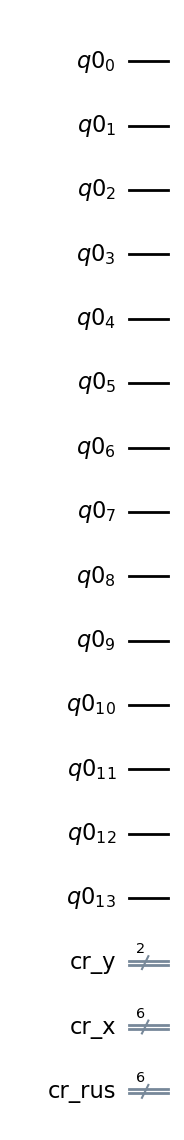

In [7]:
initial_state = initialize_circuit()

initial_state.draw(output="mpl")

### 2-2. Angle Encoding

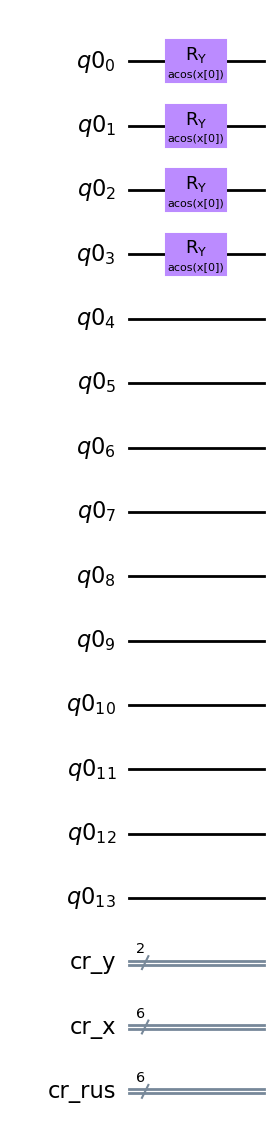

In [8]:
def encode_angle(qc, input_data, qr_data, n_data_qubits):
    # input_data /= np.max(np.abs(input_data),axis=0)
    encoded_angle = np.arccos(input_data)
    for i in range(n_data_qubits):
        qc.ry(encoded_angle, qr_data[i])
    return qc

# The circuit encoding our qubit
encoding_circuit = encode_angle(initialize_circuit(), input_seq[0], reg_d, N_QUBITS)
encoding_circuit.draw("mpl")

### 2-3. Arbitrary single-qubit gates

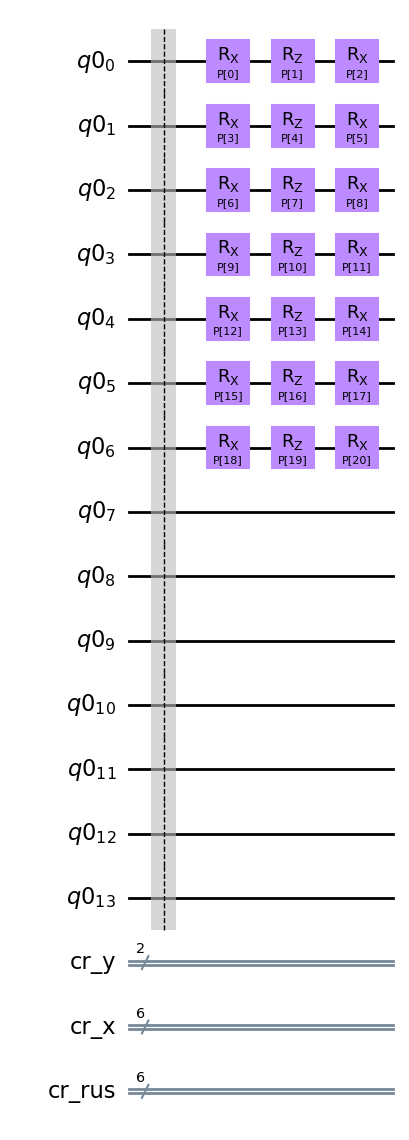

In [9]:
def apply_single_qubit_gates(qc, qr_ansatz, params, n_ansatz_qubits):
    if not isReal:
        qc.barrier()
    for i in range(n_ansatz_qubits):
        qc.rx(params[3*i], qr_ansatz[i])
        qc.rz(params[3*i+1], qr_ansatz[i])
        qc.rx(params[3*i+2], qr_ansatz[i])
    return qc

single_rotation = apply_single_qubit_gates(initialize_circuit(), reg_ansatz, params[0:3*N_ANSATZ_QUBITS], N_ANSATZ_QUBITS)
single_rotation.draw("mpl")

### 2-4. Rzz gates

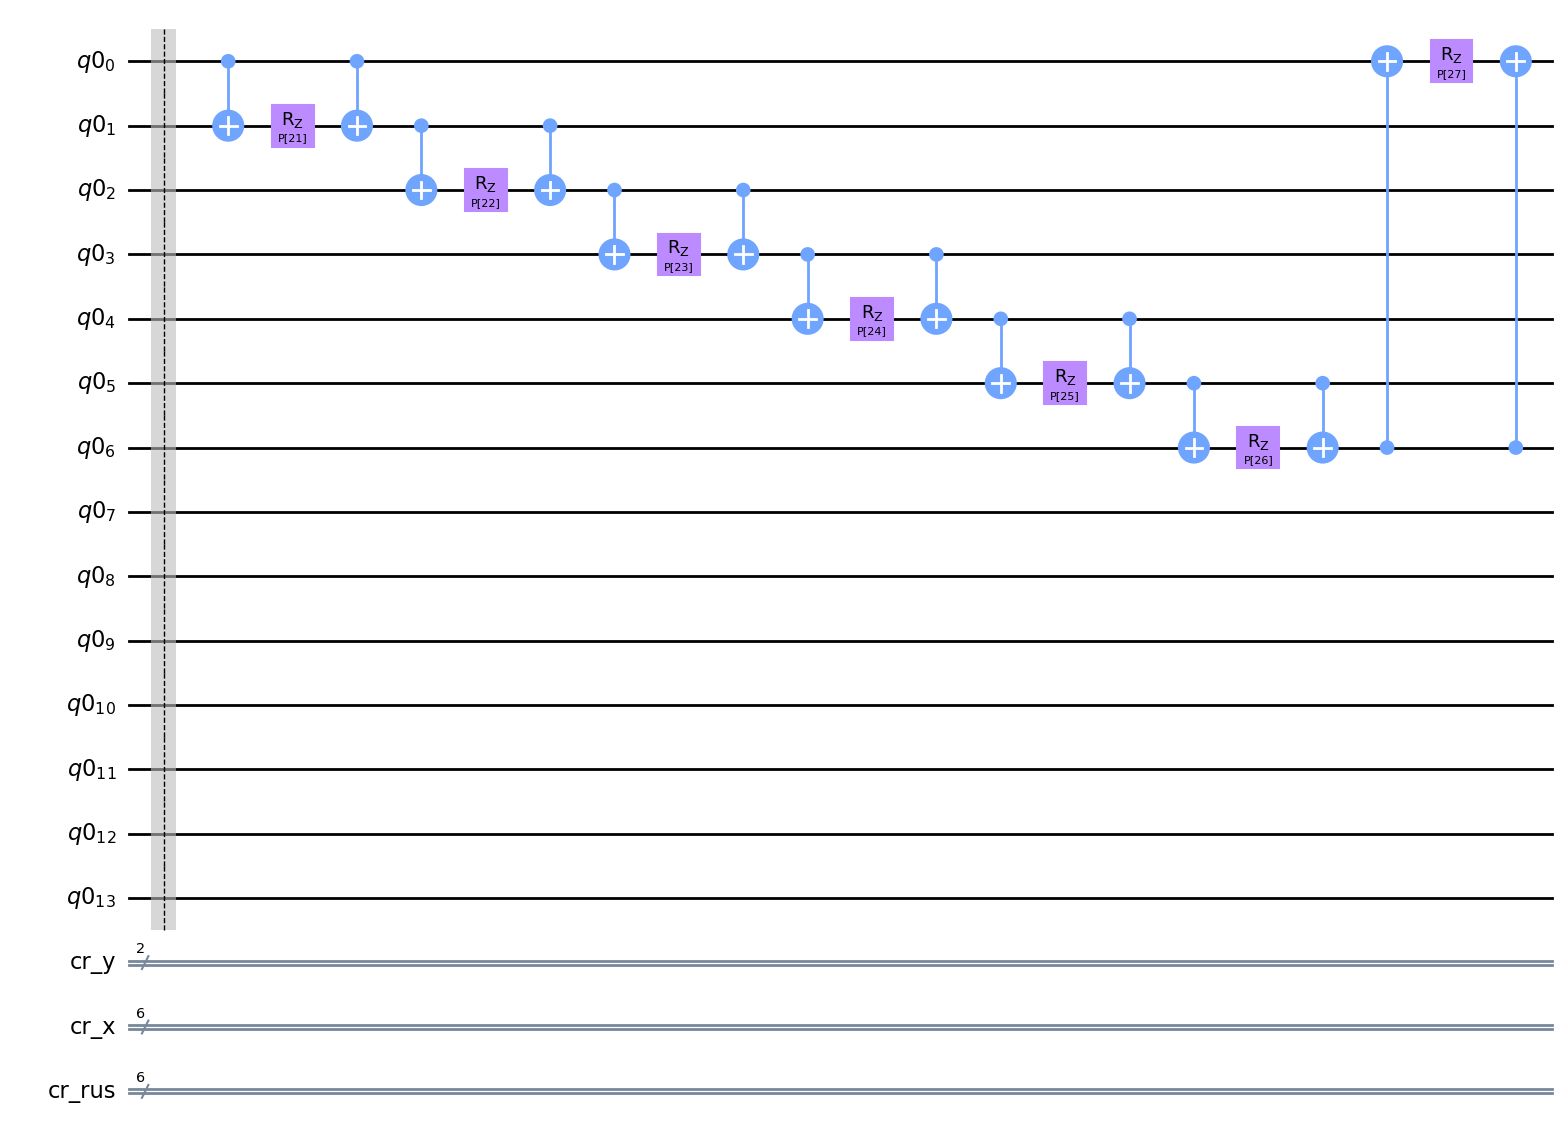

In [10]:
def apply_two_qubit_gates(qc, qr_ansatz, params, n_ansatz_qubits):
    if not isReal:
        qc.barrier()
    for i in range(-n_ansatz_qubits, 0):
        qc.cx(qr_ansatz[i], qr_ansatz[i+1])
        qc.rz(params[i], qr_ansatz[i+1])
        qc.cx(qr_ansatz[i], qr_ansatz[i+1])
    return qc

controlled_rotation = apply_two_qubit_gates(initialize_circuit(), reg_ansatz, params[3*N_ANSATZ_QUBITS:4*N_ANSATZ_QUBITS], N_ANSATZ_QUBITS)
controlled_rotation.draw("mpl")

### 2-5. Ansatz circuit

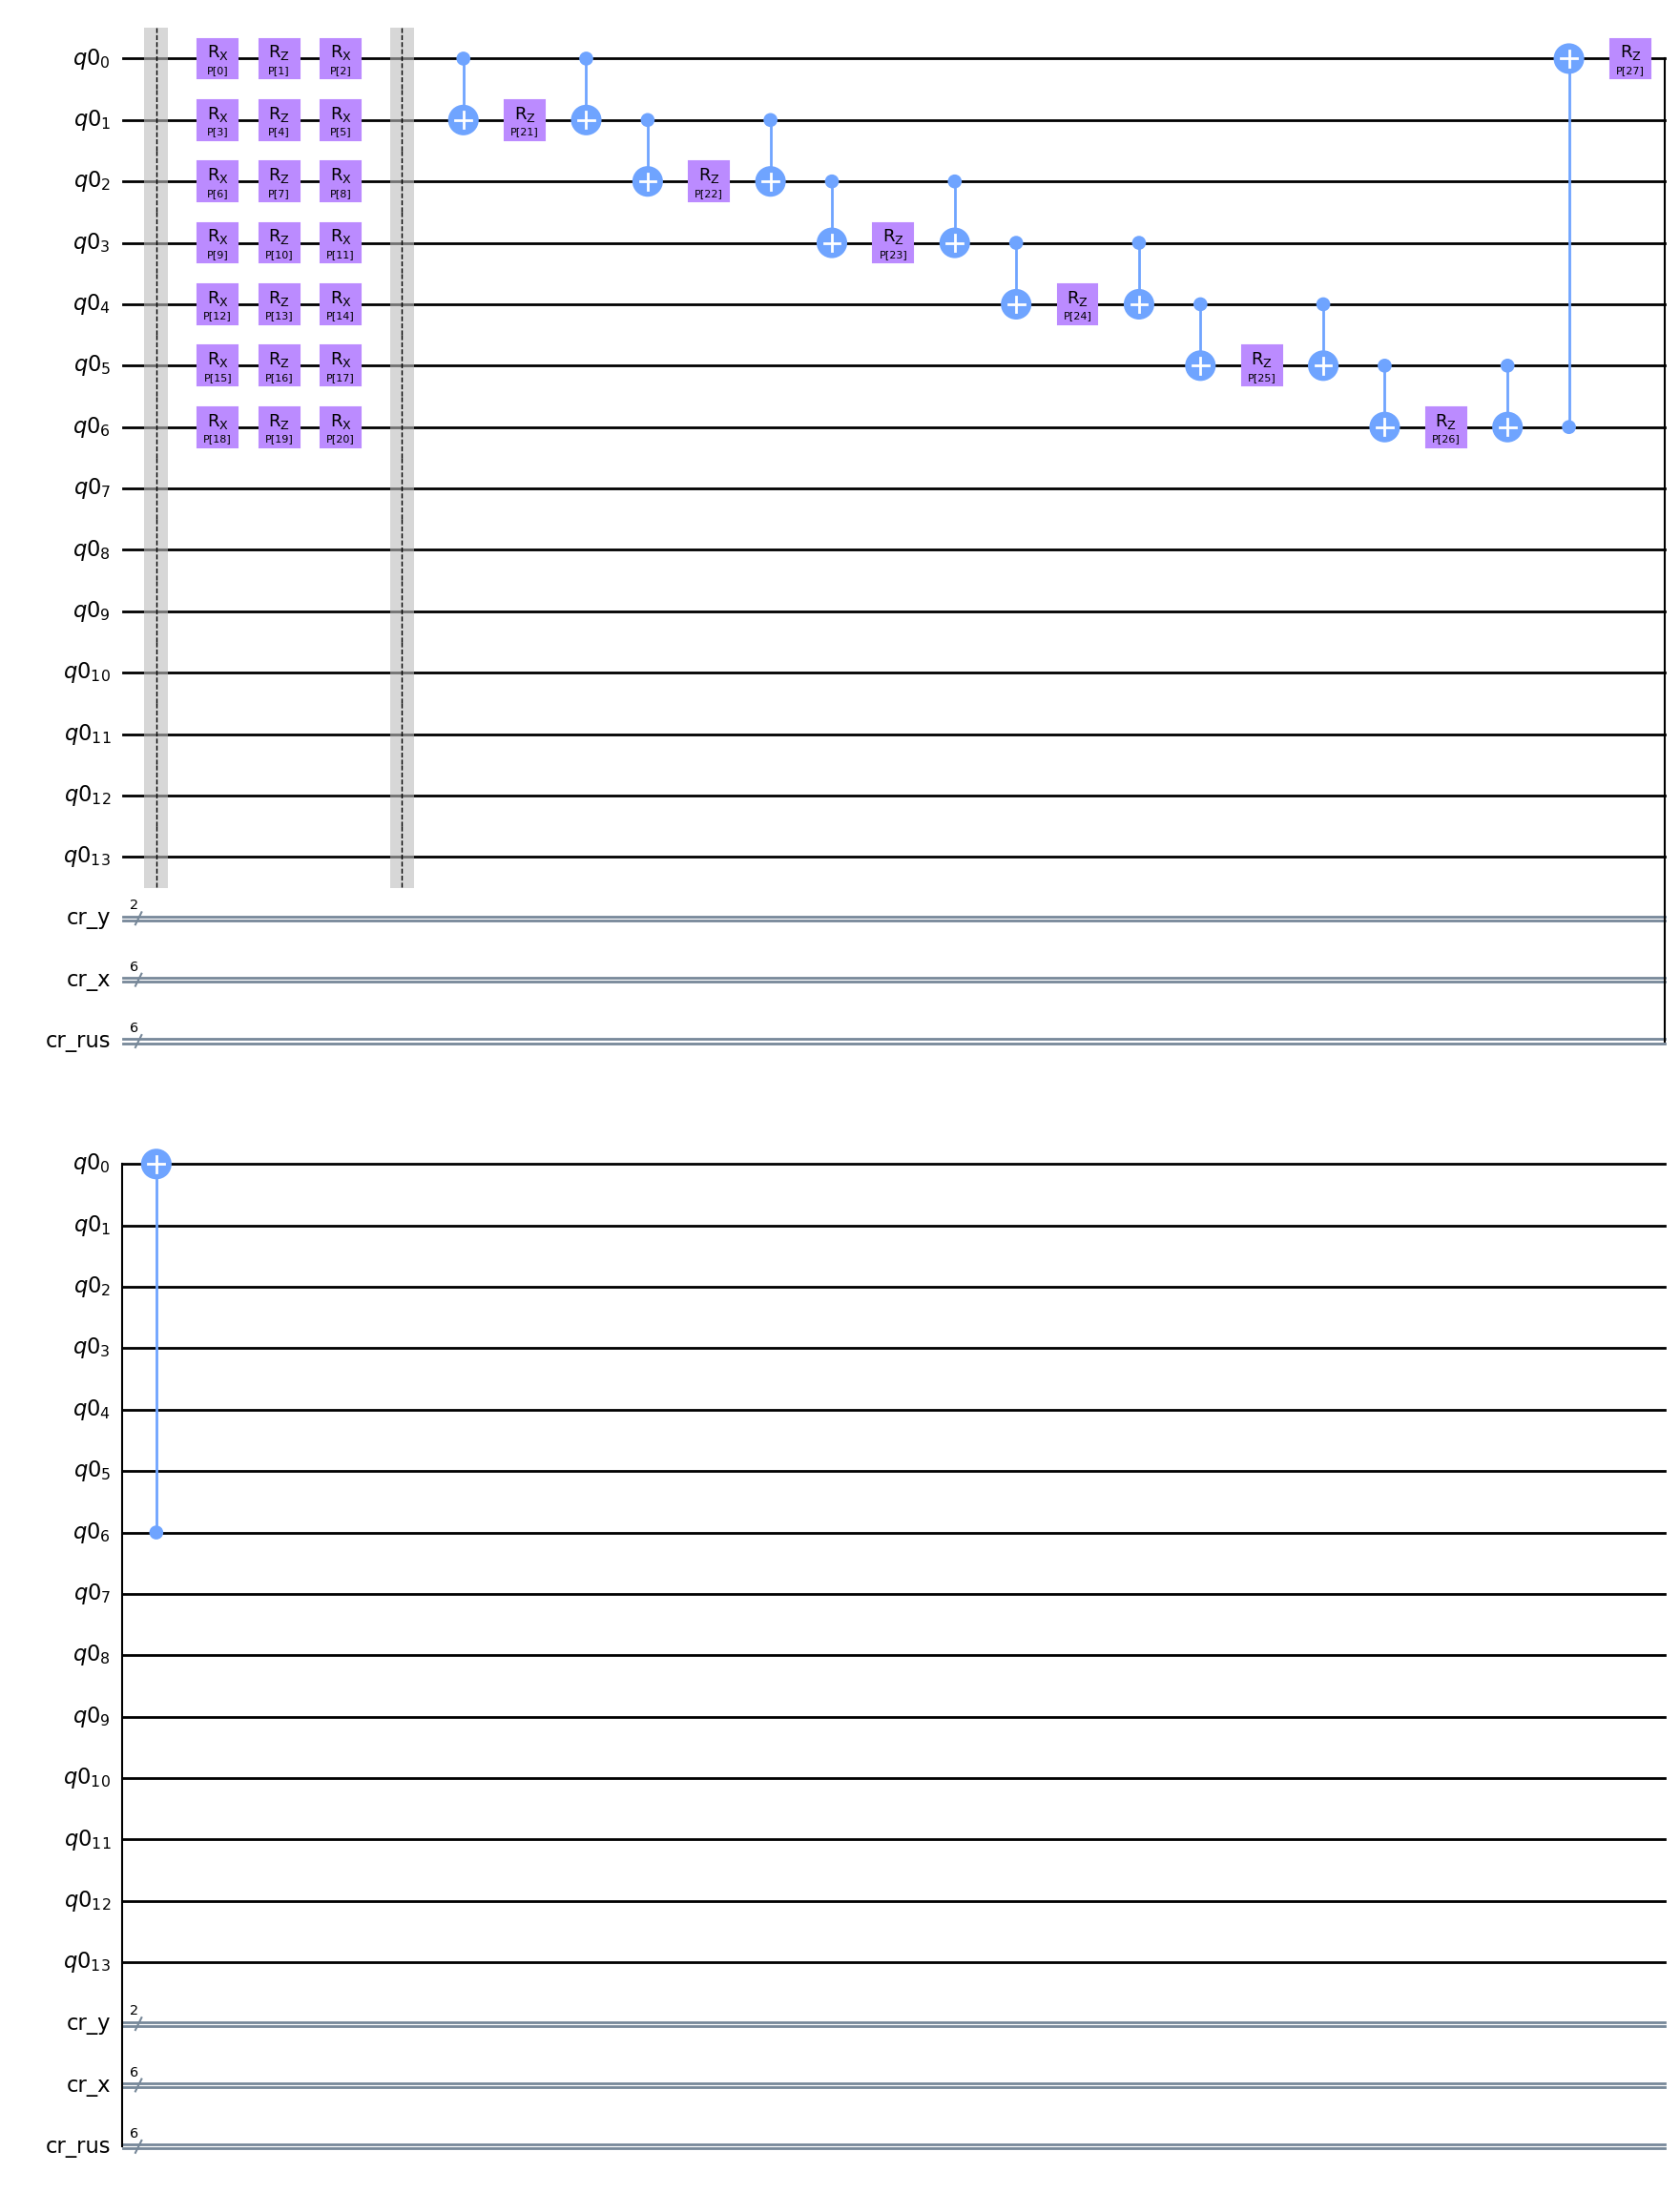

In [11]:
def apply_ansatz(qc, qr, params, n_ansatz_qubits):
    qc = apply_single_qubit_gates(qc, qr, params[0:3*n_ansatz_qubits], n_ansatz_qubits)
    qc = apply_two_qubit_gates(qc, qr, params[3*n_ansatz_qubits:4*n_ansatz_qubits], n_ansatz_qubits)
    return qc

ansatz_circuit = apply_ansatz(initialize_circuit(), reg_ansatz, params[0:4*N_ANSATZ_QUBITS], N_ANSATZ_QUBITS)
ansatz_circuit.draw("mpl")

### 2-6. RUS Activation Block

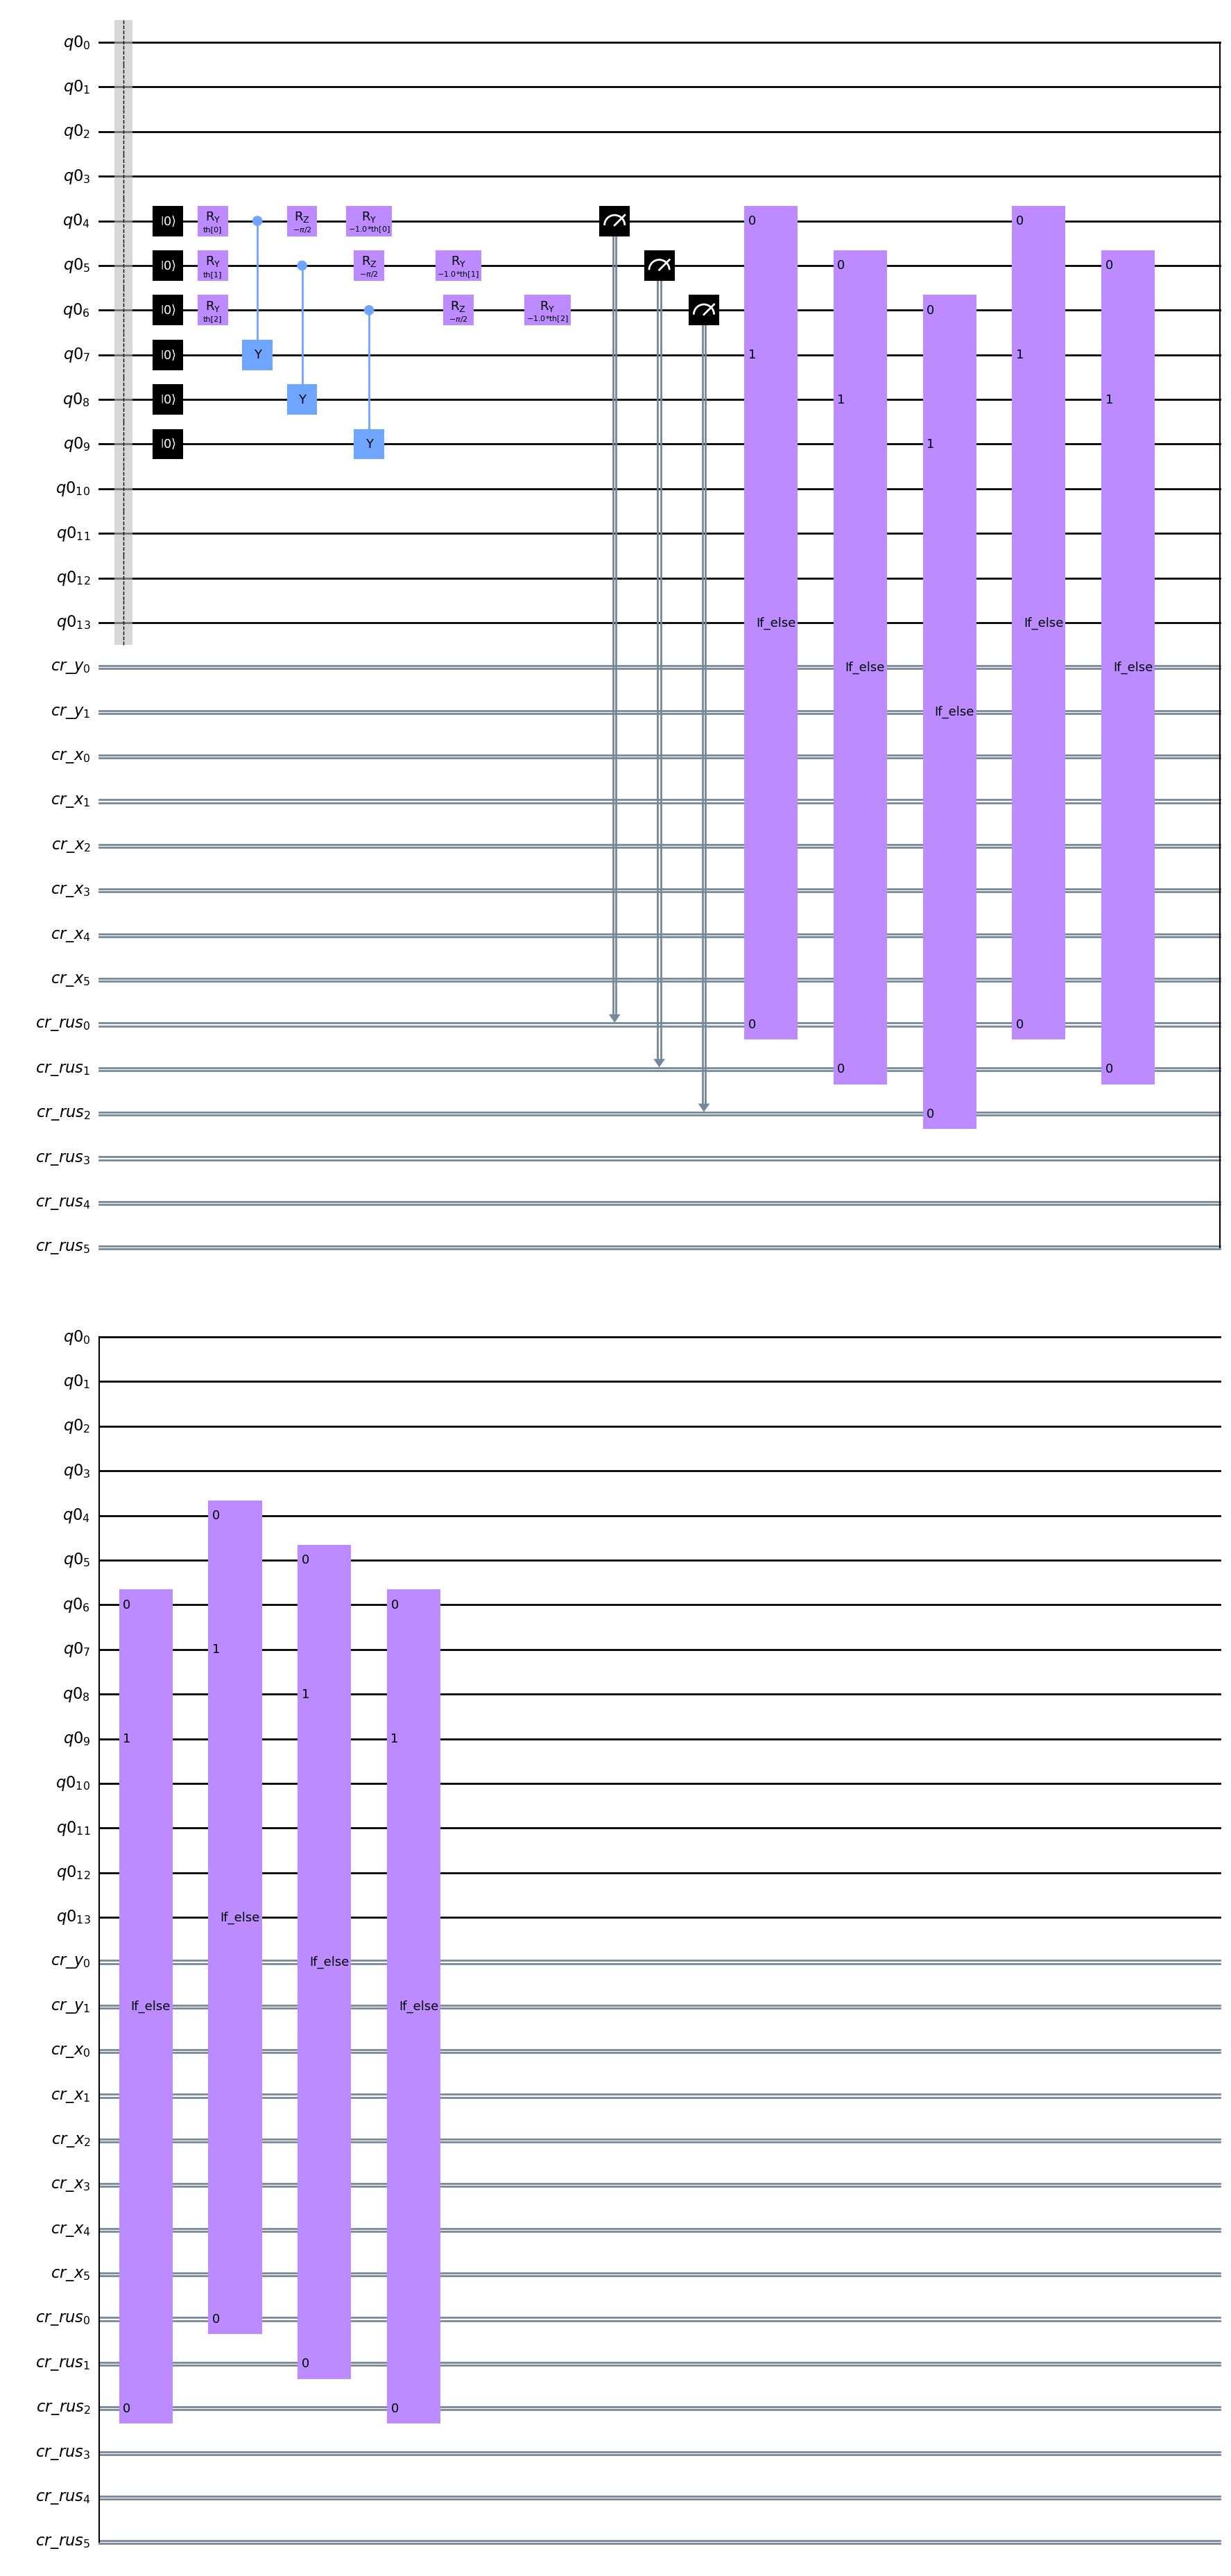

In [12]:
def apply_partial_measurement(qc, qr_data, cr_y, cr_x, n_data_qubits, n_timestep):
    if not isReal:
        qc.barrier()
    for i in range(n_data_qubits):
        if i == 0 : qc.measure(qr_data[i], cr_y[n_timestep])
        else : qc.measure(qr_data[i], cr_x[3*n_timestep+i-1])
    return qc

def apply_RUS_block_1fold(qc, qr_hid, qr_rus, cr_rus, params, n_hid_qubits, n_rus_qubits, n_timestep):
    def trial(qc, target, control, measure, theta):
        qc.ry(theta, control)
        qc.cy(control, target)
        qc.rz(-np.pi/2, control)
        qc.ry(-theta, control)
        qc.measure(control, measure)

    def repeat_block(qc, target, control, measure, theta):
        with qc.if_test((measure, 0)) as else_:
            pass
        with else_:
            qc.x(control)
            qc.ry(-np.pi/2, target)
            trial(qc, target, control, measure, theta)

    def apply_RUS(qc, target, control, measure, theta, max_trials):
        trial(qc, target, control, measure, theta)
        for _ in range(max_trials) : repeat_block(qc, target, control, measure, theta)
        return qc

    if not isReal:
        qc.barrier()
    qc.reset(qr_hid)
    qc.reset(qr_rus)
    for i in range(n_hid_qubits):
        qc = apply_RUS(qc, qr_rus[i], qr_hid[i], cr_rus[n_timestep*n_hid_qubits+i], params[i], max_trials=3)

    return qc

qc = initialize_circuit()
qc = apply_RUS_block_1fold(qc, reg_h, reg_rus, cr_rus, rus_thetas, N_HIDDEN_QUBITS, N_RUS_QUBITS, 0)
qc.draw("mpl")

### 2-7. The quantum recurrent block

In [26]:
def swap_hid_and_rus(reg_d, reg_h, reg_rus, reg_ansatz):
    _reg_h = reg_rus
    _reg_rus = reg_h
    _reg_ansatz = reg_d + _reg_h

    return (_reg_h, _reg_rus, _reg_ansatz)

def apply_qrb(qc, reg_d, reg_h, reg_ansatz, reg_rus, cr_y, cr_x, cr_rus, params, thetas, n_data_qubits, n_ansatz_qubits, n_hid_qubits, n_rus_qubits, n_timestep):
    if n_timestep > 0:
        qc.reset(reg_d)
    qc = encode_angle(qc, input_seq[n_timestep], reg_d, n_data_qubits)
    qc = apply_ansatz(qc, reg_ansatz, params[4*n_timestep*n_ansatz_qubits:4*(n_timestep+1)*n_ansatz_qubits], n_ansatz_qubits)
    qc = apply_partial_measurement(qc, reg_d, cr_y, cr_x, n_data_qubits, n_timestep)
    qc = apply_RUS_block_1fold(qc, reg_h, reg_rus, cr_rus, thetas, n_hid_qubits, n_rus_qubits, n_timestep)
    return qc

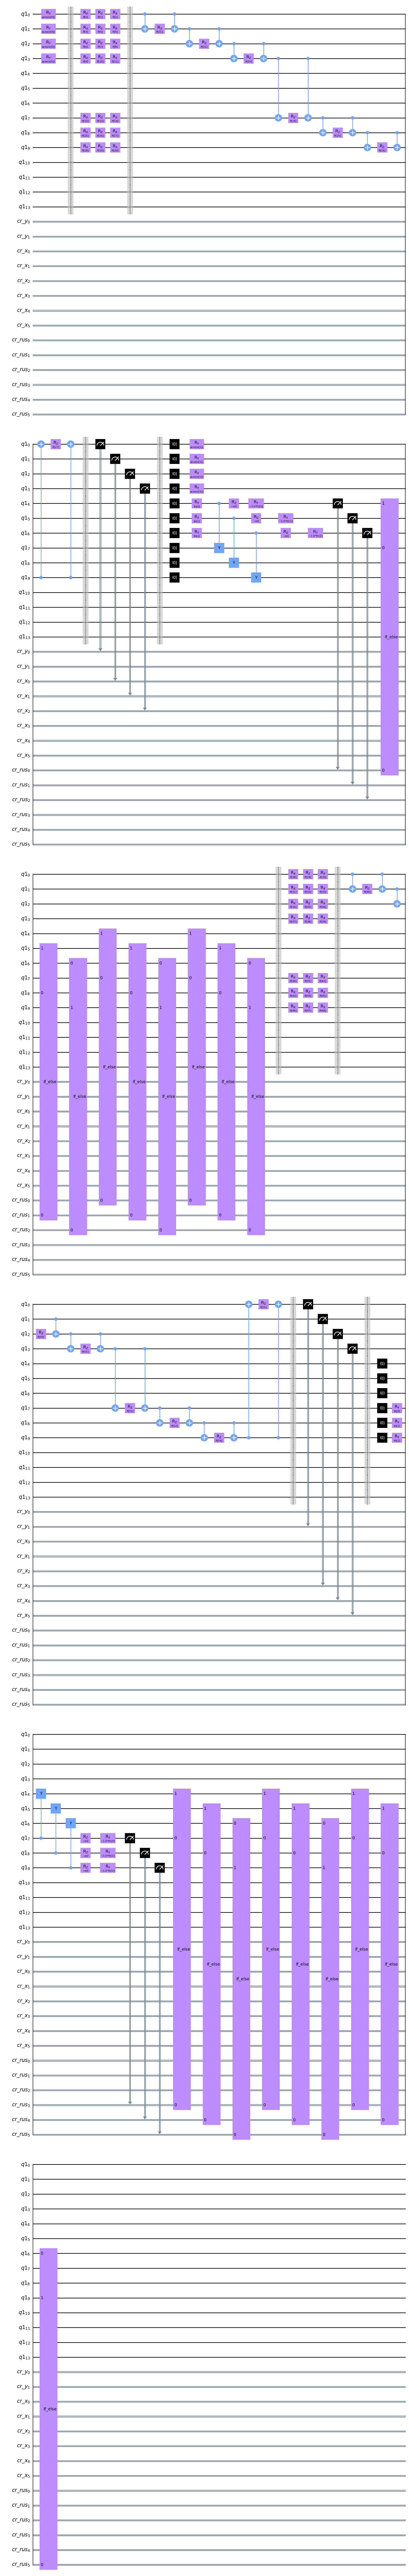

In [27]:
reg_d = qr_ansatz[0:N_QUBITS]
reg_h = qr_ansatz[N_QUBITS:N_ANSATZ_QUBITS]
reg_ansatz = qr_ansatz[0:N_ANSATZ_QUBITS]
reg_rus = qr_ansatz[N_ANSATZ_QUBITS:N_TOTAL_QUBITS]

pqrnn_circuit = initialize_circuit()
for step in range(N_STEPS):
    pqrnn_circuit = apply_qrb(pqrnn_circuit, reg_d, reg_h, reg_ansatz, reg_rus, cr_y, cr_x, cr_rus, params, rus_thetas, N_QUBITS, N_ANSATZ_QUBITS, N_HIDDEN_QUBITS, N_RUS_QUBITS, step)
    (reg_h, reg_rus, reg_ansatz) = swap_hid_and_rus(reg_d, reg_h, reg_rus, reg_ansatz)

pqrnn_circuit.draw("mpl")

In [15]:
"""
from qiskit.quantum_info import SparsePauliOp

observable = SparsePauliOp("ZZZZZZ")

from qiskit.primitives import Estimator

estimator = Estimator() #backend=backend)
parameter_values = np.random.rand(50)

job = estimator.run(sqrnn_circuit, observable, parameter_values)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Job Status: {job.status()}")
"""

'\nfrom qiskit.quantum_info import SparsePauliOp\n\nobservable = SparsePauliOp("ZZZZZZ")\n\nfrom qiskit.primitives import Estimator\n\nestimator = Estimator() #backend=backend)\nparameter_values = np.random.rand(50)\n\njob = estimator.run(sqrnn_circuit, observable, parameter_values)\nprint(f">>> Job ID: {job.job_id()}")\nprint(f">>> Job Status: {job.status()}")\n'

In [16]:
#print(job.result())

In [17]:
"""
#backend = Aer.get_backend("qasm_simulator")
#sampler = Sampler("ibmq_qasm_simulator", options={'shots':N_SHOTS, 'seed':SEED})
#estimator = Estimator(options={'shots':N_SHOTS, 'seed':SEED})

sqrnn = EstimatorQNN(
    circuit=sqrnn_circuit,
    input_params=input_seq,
    weight_params=params,
    estimator=estimator
)

print(f"num_inputs: {sqrnn.num_inputs}")
print(f"num_weights: {sqrnn.num_weights}")
print(f"observables: {sqrnn.observables}")
print(f"output_shape: {sqrnn.output_shape}")
"""

'\n#backend = Aer.get_backend("qasm_simulator")\n#sampler = Sampler("ibmq_qasm_simulator", options={\'shots\':N_SHOTS, \'seed\':SEED})\n#estimator = Estimator(options={\'shots\':N_SHOTS, \'seed\':SEED})\n\nsqrnn = EstimatorQNN(\n    circuit=sqrnn_circuit,\n    input_params=input_seq,\n    weight_params=params,\n    estimator=estimator\n)\n\nprint(f"num_inputs: {sqrnn.num_inputs}")\nprint(f"num_weights: {sqrnn.num_weights}")\nprint(f"observables: {sqrnn.observables}")\nprint(f"output_shape: {sqrnn.output_shape}")\n'

In [18]:
"""
forward = sqrnn.forward(input_data=parameter_values[0:2], weights=parameter_values[2:50])
print(forward)
"""

'\nforward = sqrnn.forward(input_data=parameter_values[0:2], weights=parameter_values[2:50])\nprint(forward)\n'

In [19]:
"""
def cost_func(params_values):
    probabilities = qnn.forward(input_seq, params_values)
    # we pick a probability of getting 1 as the output of the network
    cost = np.sum(probabilities[:, 1])

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    return cost

def cost_func_digits(params_values):
    probabilities = qnn.forward(train_images, params_values)
    cost = np.sum(probabilities[:, 1]) / train_images.shape[0]

    # plotting part
    clear_output(wait=True)
    objective_func_vals.append(cost)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

    return cost
    """

'\ndef cost_func(params_values):\n    probabilities = qnn.forward(input_seq, params_values)\n    # we pick a probability of getting 1 as the output of the network\n    cost = np.sum(probabilities[:, 1])\n\n    # plotting part\n    clear_output(wait=True)\n    objective_func_vals.append(cost)\n    plt.title("Objective function value against iteration")\n    plt.xlabel("Iteration")\n    plt.ylabel("Objective function value")\n    plt.plot(range(len(objective_func_vals)), objective_func_vals)\n    plt.show()\n    return cost\n\ndef cost_func_digits(params_values):\n    probabilities = qnn.forward(train_images, params_values)\n    cost = np.sum(probabilities[:, 1]) / train_images.shape[0]\n\n    # plotting part\n    clear_output(wait=True)\n    objective_func_vals.append(cost)\n    plt.title("Objective function value against iteration")\n    plt.xlabel("Iteration")\n    plt.ylabel("Objective function value")\n    plt.plot(range(len(objective_func_vals)), objective_func_vals)\n    plt.show(